# 06 - Final Evaluation and Interpretation

I will be conducting further analysis of the "best" model I created. The "best" model was determined to be the hypertuned Logistic Regression Model trained on the full dataset. In this step, I will be generating more visualizations in order to understand how well this model accomplishes the goal, where it is failing, and how it is coming up with its predictions.

## Imports and Loading Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Load Data
df = pd.read_csv('/Users/zulykathlucero/Desktop/predicting-employee-attrition/data/processed/features_full.csv')

# Display all columns in pandas output (otherwise the columns are truncated)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Recreating Best Model

In [2]:
# Splitting Data
target = 'Attrition'

# Separate target from full dataset
X = df.drop(columns=target)
y = df[target]

# 70/30 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Hypertuning the model
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid_lr, cv=5, scoring='recall') # prioritize recall
lr.fit(X_train, y_train)
best_lr = lr.best_estimator_ # Saving the best version of the model to use in the ensemble model

## Final Model Evaluation

The classification report shows metrics on both classes, but the metric we want to focus on is the recall of class 1 (how well the model catches employees at risk of leaving the company). We prioritize this metric because missing an employee at risk of leaving could mean higher attrition rates, but mistakenly identifying an employee as at risk of leaving won't cost the company much.  As a company, we would rather spend unnecessary time and resources making our employees feel comfortable working here than turn a blind eye to an employee who is not happy working with us. This report shows that we are identifying employees at risk of leaving correctly 68% of the time. This value is much higher than the value we started out with. Through hyperparameter tuning and adjusting for class imbalance, we were able to raise recall significantly. We are seeing a very low precision value of 0.38 for the attrition class, but that is a trade-off I am comfortable with because of the low cost of misidentifying an employee who is actually not at risk of leaving. The F1 score of 0.48 shows a moderate balance between precision and recall. The high precision, recall, and F1 scores for the non-attrition class show that model accuracy was not entirely sacrificed to accommodate for the class imbalance.

In [3]:
# getting predictions from the model
predictions = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]

# creating classification report
print("\nClassification Report:\n")
print(classification_report(y_test, predictions))


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.79      0.85       370
           1       0.38      0.68      0.48        71

    accuracy                           0.77       441
   macro avg       0.65      0.73      0.67       441
weighted avg       0.84      0.77      0.79       441



When graphing the ROC curve, we can see the tradeoff between true positive rate and false positive rate. We can compare this to random classification (modeled by the grey dashed line). Our ROC AUC is around 0.81, which suggests our model can distinguish between employees at risk of leaving versus those who aren't. Once again, we can see that our efforts to improve recall have not compromised the overall classification abilities of the model.

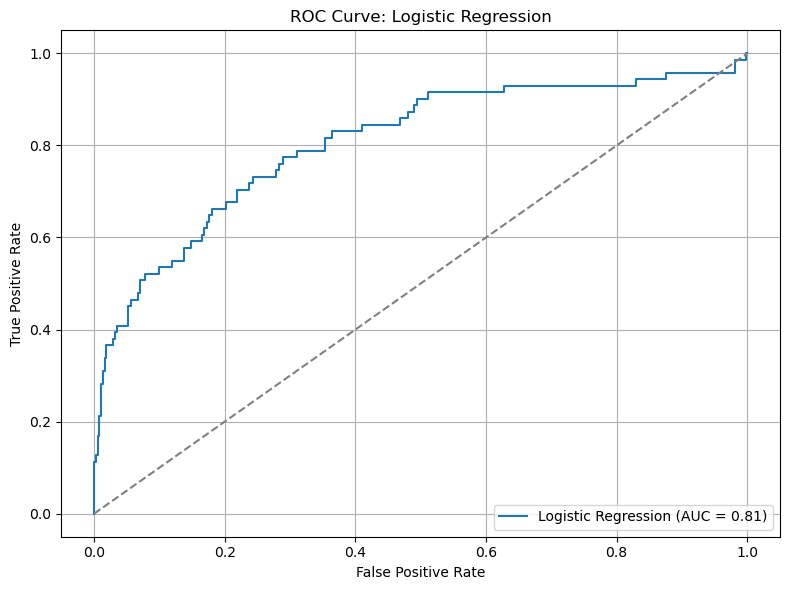

In [4]:
# graphing the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'/Users/zulykathlucero/Desktop/predicting-employee-attrition/reports/figures/final_ROC_curve.png')
plt.show()

## Confusion Matrix

This visualization shows the number of true positives, false positives, true negatives, and false negatives. In our model, true positives are catching employees who are at risk of leaving, false positives are flagging someone who is not at risk of leaving, true negatives are not flagging employees not at risk of leaving, and false negatives are employees who are at risk of leaving but were not flagged. The matrix shows that we only had 23 false negative cases, which shows we have done a good job of flagging as many "leavers" as possible. This visualization also does a good job of highlighting the class imbalance in "Attrition".

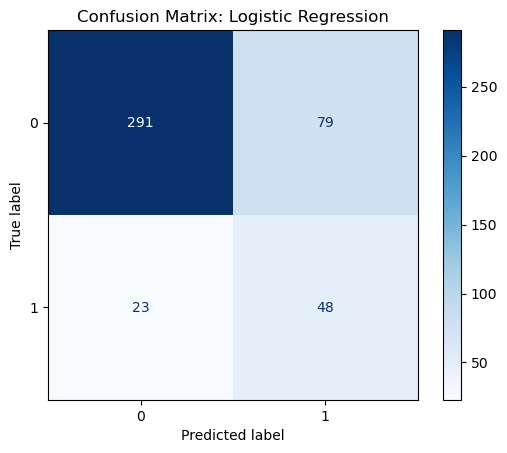

In [5]:
# creating a confusion matrix visualization
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.savefig(f'/Users/zulykathlucero/Desktop/predicting-employee-attrition/reports/figures/final_confusion_matrix.png')
plt.show()

## Feature Importance

To interpret how the model arrives at its decision, I will be ranking feature importance. Linear regression models are very interpretable since finding our feature importance can be done by looking at the coefficients assigned to each feature. We can see from the visualization that employees with the job roles of "sales representative", "sales executive", and "human resources" are more likely to be flagged as at risk for leaving the company. Some other characteristics that increase the likelihood of being flagged include frequent business travel, being a laboratory technician, and doing overtime. Employees with an educational background outside of life sciences, human resources, medicine, marketing, or technical fields were significantly less likely to be flagged by the model as at risk for attrition. These insights can help HR departments tailor the retention techniques to target the most common reasons why people are leaving the company.

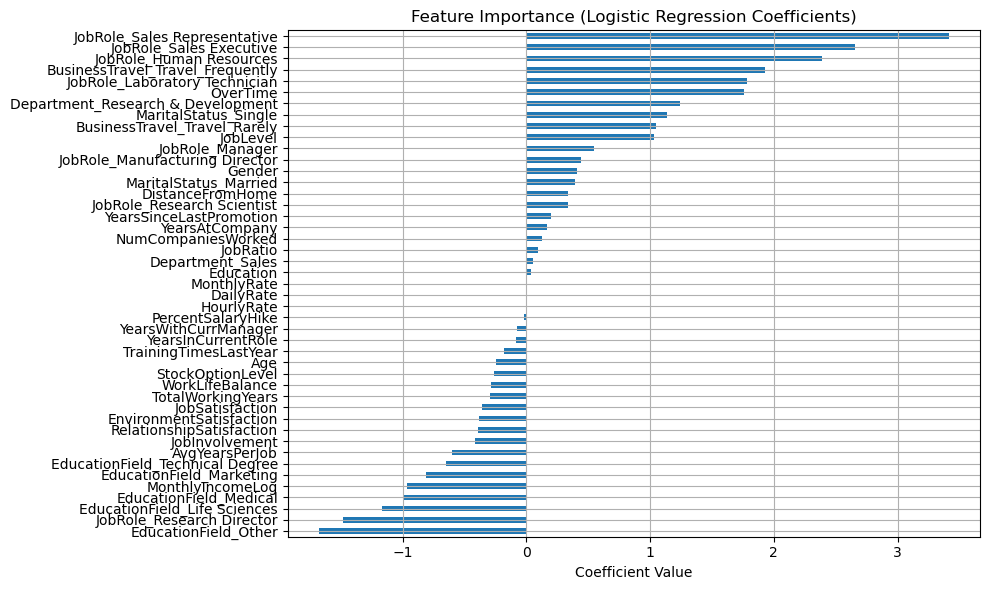

In [6]:
# getting the coefficients of the features in the model
coefs = pd.Series(best_lr.coef_[0], index=X_test.columns)
coefs_sorted = coefs.sort_values()

# plotting the coefficients
plt.figure(figsize=(10,6))
coefs_sorted.plot(kind='barh')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'/Users/zulykathlucero/Desktop/predicting-employee-attrition/reports/figures/final_feature_importance.png')
plt.show()

## Qualitative Error Analysis

To ensure I am not missing any obvious errors in the model, I looked at some employees who should have been flagged as at risk for leaving but were missed. Upon inspection, I noticed how hard it was to understand the data after it was manipulated so much during the cleaning and feature engineering process. The continuous variables have been scaled, making it harder to interpret than I expected. Among the false negatives reviewed, many employees held roles such as “Research Scientist,” which the model does not appear to associate strongly with attrition risk. These employees also tended to travel less for business and had educational backgrounds in life sciences or medicine, both of which were associated with a decreased likelihood of being flagged based on the model’s learned patterns. Their monthly incomes were close to the dataset’s average (i.e., centered around 0 in the scaled distribution). Overall, there doesn't seem to be any obvious issue with our model's decision-making, but there is room for improvement in how the model uses educational background as an indicator for attrition.

In [7]:
# Create a DataFrame with predictions and actual labels
results_df = X_test.copy()
results_df['Actual'] = y_test.values
results_df['Predicted'] = predictions
results_df['Probability'] = y_proba

# Filter: predicted 0 but actually 1 (false negatives)
false_negatives = results_df[(results_df['Predicted'] == 0) & (results_df['Actual'] == 1)]

# Display a few examples
false_negatives.sample(10)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,MonthlyIncomeLog,JobRatio,AvgYearsPerJob,Actual,Predicted,Probability
217,-0.867672,992,-1.010909,3,3,1,85,3,1,3,19757,0,0,14,4,0,-0.550208,1,2,-0.164613,2,1,5,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,-1.389541,0.545973,0.153754,1,0,0.190764
45,0.446350,1360,0.346427,3,2,0,49,3,5,3,16280,1,0,12,4,0,1.506840,0,3,2.447870,15,15,8,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,1.999398,0.848975,2.988361,1,0,0.031078
928,0.774856,621,0.716610,3,1,0,73,3,3,4,14075,1,0,11,4,1,-0.164511,2,3,0.488508,7,0,5,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,0.650241,0.981539,0.685242,1,0,0.020106
985,-0.648668,330,1.580370,4,4,1,98,3,2,3,21057,1,1,15,4,2,-0.164511,3,2,0.488508,2,6,7,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,0.265510,0.981539,0.685242,1,0,0.315606
1204,1.212863,708,-0.270544,2,4,0,95,3,1,3,11740,2,1,11,3,2,0.992578,3,3,0.325228,7,7,7,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,-1.006156,-0.623176,0.596661,1,0,0.492765
749,1.650871,266,-0.887515,1,1,0,57,1,5,4,25846,1,0,15,4,1,2.792496,3,3,4.080672,14,6,9,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,2.022334,0.889146,4.759990,1,0,0.002208
857,0.774856,1097,0.099639,4,3,1,96,3,1,3,10826,1,1,11,3,0,-0.678774,4,3,-0.164613,4,0,2,True,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,-0.854719,0.981539,-0.023409,1,0,0.264073
953,0.774856,935,-0.764121,3,1,1,89,3,1,1,14669,4,0,12,3,0,-0.164511,4,4,-0.654454,2,1,2,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,-1.182171,-1.152732,-0.643480,1,0,0.467836
864,0.446350,906,-0.517332,2,1,1,95,2,1,1,20293,6,0,17,1,1,-0.807339,2,1,-0.981014,0,0,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,-1.354125,-1.457628,-0.938751,1,0,0.491112
126,2.307882,147,1.703764,4,4,0,94,3,3,4,3465,1,0,12,4,1,3.692454,3,2,5.386914,10,15,6,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1.036624,0.981539,6.000131,1,0,0.002101


## Business Value

According to peoplekeep.com, some studies quantify the cost of losing an hourly worker as USD 1,500. Given that our model achieved a recall of 0.68, we can say that it can correctly flag about 68% of employees who will be leaving the company. In a large company, with 100 employees at risk of leaving, HR would only have to successfully intervene 30% of the time to save over USD 100,000 in recruitment and training costs. This number only rises when considering that the HR department will be more successful in their intervention with the insights provided by the model. If the intervention techniques are tailored to the reasons why the employee is choosing to leave, retention rates will skyrocket. 

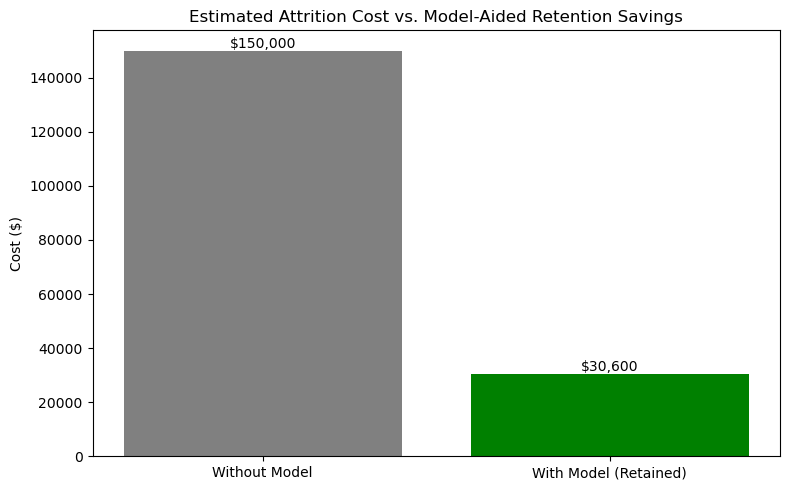

In [8]:
# Assumptions
total_at_risk = 100
cost_per_employee = 1500
retention_rate = 0.3  # percent of flagged employees successfully retained

# Calculations
retained = total_at_risk * 0.68 * retention_rate 
savings = retained * cost_per_employee
cost_without_model = total_at_risk * cost_per_employee

# Data for plot
labels = ['Without Model', 'With Model (Retained)']
values = [cost_without_model, savings]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=['gray', 'green'])
plt.ylabel('Cost ($)')
plt.title('Estimated Attrition Cost vs. Model-Aided Retention Savings')
plt.bar_label(bars, fmt='${:,.0f}')
plt.tight_layout()
plt.savefig(f'/Users/zulykathlucero/Desktop/predicting-employee-attrition/reports/figures/business_savings.png')
plt.show()

## Gender Bias

To investigate potential bias, I will be looking at model performance across different genders. 

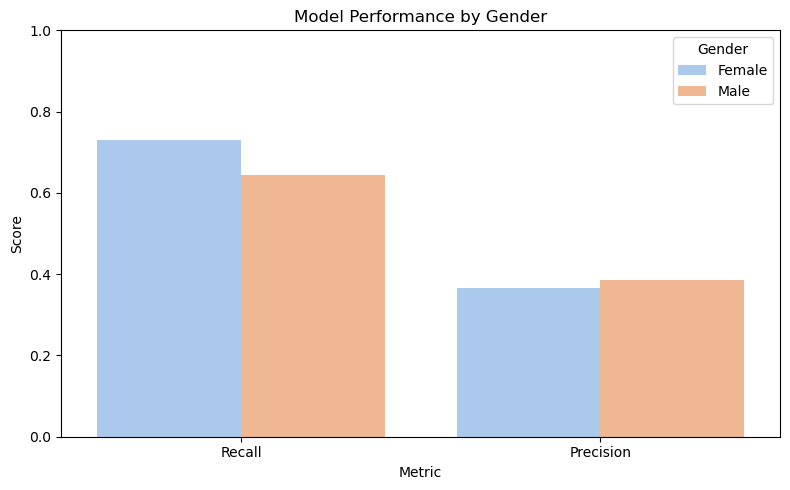

In [9]:
# Reattach Gender to your test set results
results_gender = X_test.copy()
results_gender['Actual'] = y_test.values
results_gender['Predicted'] = predictions
results_gender['Gender'] = df.loc[y_test.index, 'Gender'].values

# Split by gender
metrics = []
for gender in results_gender['Gender'].unique():
    subset = results_gender[results_gender['Gender'] == gender]
    actual = subset['Actual']
    predicted = subset['Predicted']
    
    recall = recall_score(actual, predicted)
    precision = precision_score(actual, predicted)
    
    metrics.append({
        'Gender': 'Male' if gender == 1 else 'Female',
        'Recall': recall,
        'Precision': precision
    })
bias_df = pd.DataFrame(metrics)

# Reformat data for grouped bar plot
bias_df_melted = pd.melt(bias_df, id_vars='Gender', value_vars=['Recall', 'Precision'], var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 5))
sns.barplot(data=bias_df_melted, x='Metric', y='Score', hue='Gender', palette='pastel')
plt.title('Model Performance by Gender')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.tight_layout()
plt.savefig(f'/Users/zulykathlucero/Desktop/predicting-employee-attrition/reports/figures/performance_gender.png')
plt.show()

## Key Takeaways

- The chosen model is the Logistic Regression trained on the full set of features and hypertuned using GridSearchCV. This model was chosen because of its high recall score of 0.73. It also had the highest F1 score (0.505) out of all the models made in the last step.
- When tested on the holdout testing set, the model's positive class had a recall value of 0.68, an F1 score of 0.48, and a value of 0.81 for ROC AUC. This shows success in 2 out of the 3 chosen performance metrics, with our model underperforming in terms of F1 score.
- The confusion matrix shows that our model successfully minimized the number of false negatives.
- Our feature importance visualization shows that job role and field of educational background play a big role in our model's decision-making.
- Qualitative error analysis revealed that the model’s misclassifications were generally consistent with its learned patterns. Employees missed by the model tended to belong to less-flagged job roles (e.g., Research Scientist) and had educational backgrounds that the model interpreted as low risk.
- This model focuses on minimizing the number of missed "leavers" without sacrificing overall model accuracy. There is, however, room for improvement in feature engineering and making sure that intuitive contributors to attrition are given greater weight.